[Ordinal regression](https://en.wikipedia.org/wiki/Ordinal_regression) is a classification method for categories on an ordinal scale -- e.g. [1, 2, 3, 4, 5] or [G, PG, PG-13, R].  This notebook implements ordinal regression using the method of [Frank and Hal 2001](https://www.cs.waikato.ac.nz/~eibe/pubs/ordinal_tech_report.pdf), which transforms a k-multiclass classifier into k-1 binary classifiers (each of which predicts whether a data point is above a threshold in the ordinal scale -- e.g., whether a movie is "higher" than PG).  This method can be used with any binary classification method that outputs probabilities; here L2-regularizaed binary logistic regression is used.

This notebook trains a model (on `train.txt`), optimizes L2 regularization strength on `dev.txt`, and evaluates performance on `test.txt`.  Reports test accuracy with 95% confidence intervals.

In [1]:
!python -m nltk.downloader punkt_tab

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import operator
import nltk
import math
from scipy.stats import norm

# # importing numpy
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
import pandas as pd

#for confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
def load_ordinal_data(filename, ordering):
    X = []
    Y = []
    orig_Y=[]
    for ordinal in ordering:
        Y.append([])

    with open(filename, encoding="utf-8") as file:
        # Skip the header row if it exists
        next(file, None)  # Skip the first line
        for line in file:
            cols = line.split("\t")
            idd = cols[0]
            label = cols[1].lstrip().rstrip()
            text = cols[2]

            X.append(text)

            # Check if the label is in the ordering list before getting the index
            if label in ordering:
                index=ordering.index(label)
                for i in range(len(ordering)):
                    if index > i:
                        Y[i].append(1)
                    else:
                        Y[i].append(0)
                orig_Y.append(label)
            else:
                # Handle cases where the label is not in the ordering list
                print(f"Warning: Label '{label}' not in ordering list, skipping this data point.")

    return X, Y, orig_Y

In [4]:
class OrdinalClassifier:

    def __init__(self, ordinal_values, feature_method, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY):
        self.ordinal_values=ordinal_values
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=2
        self.log_regs = [None]* (len(self.ordinal_values)-1)

        self.trainY=trainY
        self.devY=devY
        self.testY=testY

        self.orig_trainY=orig_trainY
        self.orig_devY=orig_devY
        self.orig_testY=orig_testY

        self.trainX = self.process(trainX, training=True)
        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)

        self.orig_testX = testX #added this so we can look at this later along with preds and true manually
        self.y_preds = []
        self.y_truth = []
        self.texts = []

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):

        data = self.featurize(X_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        return X


    def train(self):
        (D,F) = self.trainX.shape


        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            best_dev_accuracy=0
            best_model=None
            for C in [0.1, 1, 10, 100]:

                log_reg = linear_model.LogisticRegression(C = C, max_iter=1000, class_weight='balanced')
                log_reg.fit(self.trainX, self.trainY[idx])
                development_accuracy = log_reg.score(self.devX, self.devY[idx])
                if development_accuracy > best_dev_accuracy:
                    best_dev_accuracy=development_accuracy
                    best_model=log_reg


            self.log_regs[idx]=best_model

    def test(self):
        cor=tot=0
        counts=Counter()
        preds=[None]*(len(self.ordinal_values)-1)
        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            preds[idx]=self.log_regs[idx].predict_proba(self.testX)[:,1]

        preds=np.array(preds)

        #create list to analyze prediction vs actual

        for data_point in range(len(preds[0])):


            ordinal_preds=np.zeros(len(self.ordinal_values))
            for ordinal in range(len(self.ordinal_values)-1):
                if ordinal == 0:
                    ordinal_preds[ordinal]=1-preds[ordinal][data_point]
                else:
                    ordinal_preds[ordinal]=preds[ordinal-1][data_point]-preds[ordinal][data_point]

            ordinal_preds[len(self.ordinal_values)-1]=preds[len(preds)-1][data_point]

            prediction=np.argmax(ordinal_preds)
            counts[prediction]+=1
            if prediction == self.ordinal_values.index(self.orig_testY[data_point]):
                cor+=1
            tot+=1

            #adding preds and truth to lists, and the text corresponding to it as well
            self.y_truth.append(self.ordinal_values.index(self.orig_testY[data_point]))
            self.y_preds.append(prediction)
            self.texts.append(self.orig_testX[data_point])

        return cor/tot

In [5]:
def binary_bow_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        feats[word]=1

    return feats

In [6]:
# # bow + the certainty_featurize
def bow_plus_certainty_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    # Bag-of-Words features (binary)
    for word in words:
        word = word.lower()
        feats[word] = 1

    # Certainty Features
    hedge_words = [
        "may", "might", "could", "possibly", "perhaps", "likely", "unlikely", "seem",
        "appears", "appeared", "appearing", "suggest", "suggests", "suggested",
        "to some extent", "to a degree", "it is possible that", "possible", "uncertain",
        "assume", "assumed", "assuming", "hypothesize", "hypothesized", "hypothetically",
        "speculate", "speculated", "speculating", "theoretically", "potential", "potentially",
        "presumably", "presume", "presumed", "estimate", "estimated", "approximately", "roughly",
        "tentative", "tentatively", "imply", "implies", "implied", "indicate", "indicates", "indicated",
        "infer", "inferred", "infers", "anticipated", "anticipate", "anticipates", "at times", "occasionally",
        "sometimes", "periodically", "project", "projected", "proposed", "propose", "proposes",
        "partially", "in part", "debated", "arguably", "may well", "remains to be seen", "uncertainty",
        "possibility", "it remains unclear", "there is room for", "ongoing debate", "unresolved",
        "lack of consensus", "under discussion", "open question", "disputed", "contentious",
        "suggesting", "assumedly", "conjecture"
    ]

    assertive_words = [
        "demonstrate", "demonstrates", "demonstrated", "confirm", "confirms", "confirmed",
        "prove", "proves", "proved", "proven", "show", "shows", "showed", "reveals", "revealed", "reveal",
        "establish", "establishes", "established", "validate", "validates", "validated", "verify", "verified",
        "supports", "support", "supported", "evident", "evidence", "obvious", "obviously", "clear", "clearly",
        "manifest", "manifested", "unquestionable", "unquestionably", "undeniable", "undoubtedly",
        "without a doubt", "definitive", "definitely", "certainly", "certainty", "determines", "determine",
        "determined", "strongly suggest", "strongly supports", "indisputable", "documented",
        "observed", "observations show", "corroborate", "corroborated", "corroborates", "solid evidence",
        "well-established", "verified", "authenticated", "conclude", "concludes", "concluded",
        "undisputed", "resoundingly", "empirically", "empirical evidence", "well documented", "proven fact"
    ]

    text_lower = text.lower()
    tokens = text_lower.split()

    # Hedge count
    hedge_count = sum(any(hw in token for hw in hedge_words) for token in tokens)
    feats['hedge_count'] = hedge_count
    # feats['__hedge_count'] = hedge_count / num_words  # normalized


    # Assertive count
    assertive_count = sum(any(aw in token for aw in assertive_words) for token in tokens)
    feats['assertive_count'] = assertive_count
    # feats['__assertive_count'] = assertive_count / num_words  # normalized

    # Question presence
    feats['question_mark'] = int('?' in text)

    return feats


In [7]:
def bert_certainty_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    # Bag-of-Words features (binary)
    for word in words:
        word = word.lower()
        feats[word] = 1

    # Certainty Features
    hedge_words = [
        "may", "might", "could", "possibly", "perhaps", "likely", "seems",
        "appears", "suggests", "to some extent", "possible"
    ]
    assertive_words = [
        "demonstrates", "confirms", "proves", "shows", "reveals", "establishes",
        "confirm", "conclude"
    ]

    text_lower = text.lower()
    tokens = text_lower.split()
    num_words = len(tokens) if len(tokens) > 0 else 1  # Prevent division by zero

    # Hedge count
    hedge_count = sum(any(hw in token for hw in hedge_words) for token in tokens)
    feats['hedge_count'] = hedge_count
    # feats['__hedge_count'] = hedge_count / num_words  # normalized!


    # Assertive count
    assertive_count = sum(any(aw in token for aw in assertive_words) for token in tokens)
    feats['assertive_count'] = assertive_count
    # feats['__assertive_count'] = assertive_count / num_words  # normalized!

    # Question presence
    feats['__question_mark'] = int('?' in text)

    return feats

In [8]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [9]:
def run(trainingFile, devFile, testFile, ordinal_values, features):


    trainX, trainY, orig_trainY=load_ordinal_data(trainingFile, ordinal_values)
    devX, devY, orig_devY=load_ordinal_data(devFile, ordinal_values)
    testX, testY, orig_testY=load_ordinal_data(testFile, ordinal_values)

    simple_classifier = OrdinalClassifier(ordinal_values, features, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY)
    simple_classifier.train()
    accuracy=simple_classifier.test()

    lower, upper=confidence_intervals(accuracy, len(testY[0]), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

    #build a dataframe including test text, predicted labels, and actual labels
    results_df = pd.DataFrame({
        'True Label': [simple_classifier.ordinal_values[i] for i in simple_classifier.y_truth],
        'Predicted Label': [simple_classifier.ordinal_values[i] for i in simple_classifier.y_preds],
        'Abstract': simple_classifier.texts
    })

    #only interested in seeing rows where the labels (pred vs true) are different to understand errors in models
    results_df['Correct'] = results_df['True Label'] == results_df['Predicted Label']
    incorrect_df = results_df[results_df['Correct'] == False] #filter out ones where they are the same

    #confusion matrix
    cm = confusion_matrix(simple_classifier.y_truth, simple_classifier.y_preds)
    sns.heatmap(cm, annot=True,
                xticklabels=ordinal_values, yticklabels=ordinal_values)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    pd.set_option('display.max_colwidth', None)  #need to see whole text

    #display true vs preds where they are diff
    display(incorrect_df)



Test accuracy for best dev model: 0.460, 95% CIs: [0.362 0.558]



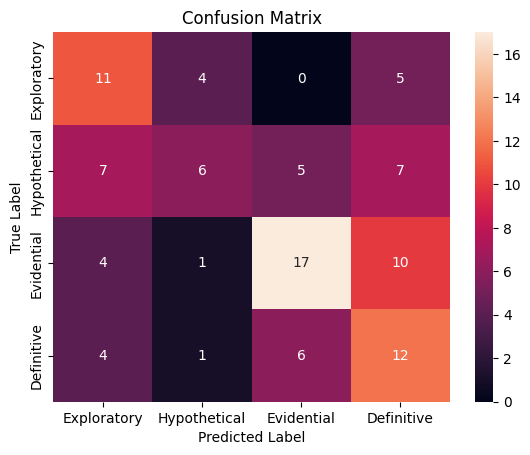

,True Label,Predicted Label,Abstract,Correct
2,Hypothetical,Exploratory,"Climate change and development of data-oriented methods are appealing for new climate classification schemes. Based on the most widely used Köppen-Geiger scheme, this article proposes a neural network based climate classification method from a data science perspective. In conventional schemes, empirically handcrafted rules are used to divide climate data into climate types, resulting in certain defects. In the proposed method, a machine learning mechanism is employed to do the task. Specifically, the method first trains a convolutional neural network to fit climate data to land cover conditions, then extracts features from the trained network and finally uses a self-organizing map to cluster land pixels on the extracted features. The method is applied to cluster global land represented by 66,501 pixels (each covers 0.5 latitude degree × 0.5 longitude degree) using 2020 land cover data and 1991-2020 climate normals, and a 4 × 3 × 2 hexagonal self-organizing map clusters the land pixels into twenty-four climate types. By Kappa statistics, the obtained scheme shows good agreement with the Köppen-Geiger and Köppen-Trewartha schemes. In addition, our scheme addresses some issues of the Köppen schemes, suggests new climate types such as As (severe dry-wet season) and Fw (arctic desert), and identifies the highland group H without input of elevation. The proposed method is expected as an intelligent tool to monitor changes in the global climate pattern and to discover new climate types of interest that possibly emerge in the future. It may also be valuable for bio-ecology communities.\n",False
4,Definitive,Exploratory,"Peatlands throughout the boreal forest are expected to experience changes in precipitation, evapotranspiration and temperature due to climate change. Correspondingly, changes in hydrologic regimes could lead to increased drought and occurrence of wildfire. Fire management agencies require information about near-real time wildfire vulnerability in boreal peatlands. Remote sensing tools (e.g., NDVI, NDII) to monitor changing wildfire vulnerability focus on monitoring changes in vascular vegetation and are not necessarily applicable to moss-dominated peatlands. We use time series analysis of Sentinel-1 SAR backscatter data to compare the trends in peatlands that have burned to unburned peatlands and show that the Theil-Sen slopes of seasonally decomposed SAR backscatter reflects prolonged drought conditions that can lead to burning. Seasonally decomposed Sentinel-2 NDVI and NDII were also tested but no statistical differences were found between burned and unburned peatlands. Overall, we found that 6 months prior to a wildfire the slope of seasonally decomposed Sentinel-1 VV SAR backscatter was significantly different in burned and unburned peatlands, and can be used to spatially identify fire vulnerability and identify fire-prone areas.\n",False
5,Exploratory,Definitive,"Mapping carbon stocks in the tropics is essential for climate change mitigation. Passive microwave remote sensing allows estimating carbon from deep canopy layers through the Vegetation Optical Depth (VOD) parameter. Although their spatial resolution is coarser than that of optical vegetation indices or airborne Lidar data, microwaves present a higher penetration capacity at low frequencies (Lband) and avoid cloud masking. This work compares the relationships of airborne carbon maps in Central and South America with both (i) SMAP L-band VOD at 9 km gridding and (ii) MODIS Enhanced Vegetation Index (EVI). Models to estimate carbon stocks are built from these two satellite derived variables. Results show that L-band VOD has a greater capacity to model carbon variability than EVI. The resulting VOD-derived carbon estimates are further presented at a detailed (9 km) spatial scale.\n",False
6,Exploratory,Definitive,"Although study of the effect of energy-absorbing gases in our atmosphere 

In [11]:
trainingFile = "splits/train.txt"
devFile = "splits/dev.txt"
testFile = "splits/test.txt"

# ordinal values must be in order *as strings* from smallest to largest, e.g.:
# ordinal_values=["G", "PG", "PG-13", "R"]

ordinal_values=["Exploratory", "Hypothetical", "Evidential", "Definitive"]

run(trainingFile, devFile, testFile, ordinal_values, bow_plus_certainty_featurize)

Test accuracy for best dev model: 0.380, 95% CIs: [0.285 0.475]



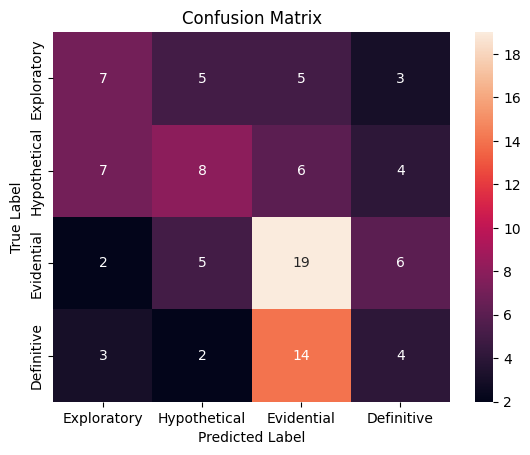

,True Label,Predicted Label,Abstract,Correct
0,Exploratory,Hypothetical,"Identifying and characterising dynamical regime shifts, critical transitions or potential tipping points in palaeoclimate time series is relevant for improving the understanding of often highly nonlinear Earth system dynamics. Beyond linear changes in time series properties such as mean, variance, or trend, these nonlinear regime shifts can manifest as changes in signal predictability, regularity, complexity, or higher-order stochastic properties such as multi-stability. In recent years, several classes of methods have been put forward to study these critical transitions in time series data that are based on concepts from nonlinear dynamics, complex systems science, information theory, and stochastic analysis. These include approaches such as phase space-based recurrence plots and recurrence networks, visibility graphs, order pattern-based entropies, and stochastic modelling. Here, we review and compare in detail several prominent methods from these fields by applying them to the same set of marine palaeoclimate proxy records of African climate variations during the past 5~million years. Applying these methods, we observe notable nonlinear transitions in palaeoclimate dynamics in these marine proxy records and discuss them in the context of important climate events and regimes such as phases of intensified Walker circulation, marine isotope stage M2, the onset of northern hemisphere glaciation and the mid-Pleistocene transition. We find that the studied approaches complement each other by allowing us to point out distinct aspects of dynamical regime shifts in palaeoclimate time series. We also detect significant correlations of these nonlinear regime shift indicators with variations of Earth's orbit, suggesting the latter as potential triggers of nonlinear transitions in palaeoclimate. Overall, the presented study underlines the potentials of nonlinear time series analysis approaches to provide complementary information on dynamical regime shifts in palaeoclimate and their driving processes that cannot be revealed by linear statistics or eyeball inspection of the data alone.\n",False
2,Hypothetical,Exploratory,"Climate change and development of data-oriented methods are appealing for new climate classification schemes. Based on the most widely used Köppen-Geiger scheme, this article proposes a neural network based climate classification method from a data science perspective. In conventional schemes, empirically handcrafted rules are used to divide climate data into climate types, resulting in certain defects. In the proposed method, a machine learning mechanism is employed to do the task. Specifically, the method first trains a convolutional neural network to fit climate data to land cover conditions, then extracts features from the trained network and finally uses a self-organizing map to cluster land pixels on the extracted features. The method is applied to cluster global land represented by 66,501 pixels (each covers 0.5 latitude degree × 0.5 longitude degree) using 2020 land cover data and 1991-2020 climate normals, and a 4 × 3 × 2 hexagonal self-organizing map clusters the land pixels into twenty-four climate types. By Kappa statistics, the obtained scheme shows good agreement with the Köppen-Geiger and Köppen-Trewartha schemes. In addition, our scheme addresses some issues of the Köppen schemes, suggests new climate types such as As (severe dry-wet season) and Fw (arctic desert), and identifies the highland group H without input of elevation. The proposed method is expected as an intelligent tool to monitor changes in the global climate pattern and to discover new climate types of interest that possibly emerge in the future. It may also be valuable for bio-ecology communities.\n",False
4,Definitive,Evidential,"Peatlands throughout the boreal forest are expected to experience changes in precipitation, evapotranspiration and temperature due to clima

In [12]:
#what if for BoW, instead of doing just existence/absence, we also take into account freq?
def frequency_bow_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word = word.lower()
        feats[word] = feats.get(word, 0) + 1

    return feats

run(trainingFile, devFile, testFile, ordinal_values, frequency_bow_featurize)

Test accuracy for best dev model: 0.400, 95% CIs: [0.304 0.496]



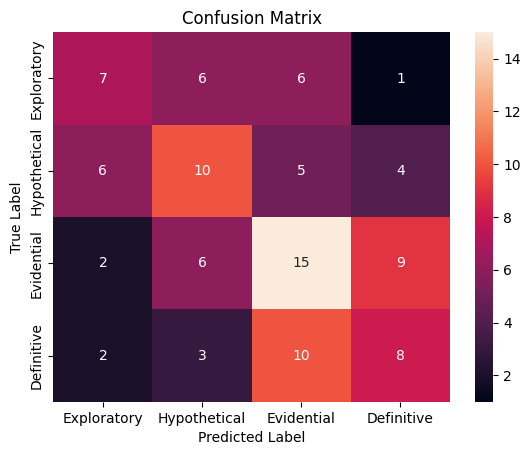

,True Label,Predicted Label,Abstract,Correct
2,Hypothetical,Exploratory,"Climate change and development of data-oriented methods are appealing for new climate classification schemes. Based on the most widely used Köppen-Geiger scheme, this article proposes a neural network based climate classification method from a data science perspective. In conventional schemes, empirically handcrafted rules are used to divide climate data into climate types, resulting in certain defects. In the proposed method, a machine learning mechanism is employed to do the task. Specifically, the method first trains a convolutional neural network to fit climate data to land cover conditions, then extracts features from the trained network and finally uses a self-organizing map to cluster land pixels on the extracted features. The method is applied to cluster global land represented by 66,501 pixels (each covers 0.5 latitude degree × 0.5 longitude degree) using 2020 land cover data and 1991-2020 climate normals, and a 4 × 3 × 2 hexagonal self-organizing map clusters the land pixels into twenty-four climate types. By Kappa statistics, the obtained scheme shows good agreement with the Köppen-Geiger and Köppen-Trewartha schemes. In addition, our scheme addresses some issues of the Köppen schemes, suggests new climate types such as As (severe dry-wet season) and Fw (arctic desert), and identifies the highland group H without input of elevation. The proposed method is expected as an intelligent tool to monitor changes in the global climate pattern and to discover new climate types of interest that possibly emerge in the future. It may also be valuable for bio-ecology communities.\n",False
4,Definitive,Evidential,"Peatlands throughout the boreal forest are expected to experience changes in precipitation, evapotranspiration and temperature due to climate change. Correspondingly, changes in hydrologic regimes could lead to increased drought and occurrence of wildfire. Fire management agencies require information about near-real time wildfire vulnerability in boreal peatlands. Remote sensing tools (e.g., NDVI, NDII) to monitor changing wildfire vulnerability focus on monitoring changes in vascular vegetation and are not necessarily applicable to moss-dominated peatlands. We use time series analysis of Sentinel-1 SAR backscatter data to compare the trends in peatlands that have burned to unburned peatlands and show that the Theil-Sen slopes of seasonally decomposed SAR backscatter reflects prolonged drought conditions that can lead to burning. Seasonally decomposed Sentinel-2 NDVI and NDII were also tested but no statistical differences were found between burned and unburned peatlands. Overall, we found that 6 months prior to a wildfire the slope of seasonally decomposed Sentinel-1 VV SAR backscatter was significantly different in burned and unburned peatlands, and can be used to spatially identify fire vulnerability and identify fire-prone areas.\n",False
5,Exploratory,Evidential,"Mapping carbon stocks in the tropics is essential for climate change mitigation. Passive microwave remote sensing allows estimating carbon from deep canopy layers through the Vegetation Optical Depth (VOD) parameter. Although their spatial resolution is coarser than that of optical vegetation indices or airborne Lidar data, microwaves present a higher penetration capacity at low frequencies (Lband) and avoid cloud masking. This work compares the relationships of airborne carbon maps in Central and South America with both (i) SMAP L-band VOD at 9 km gridding and (ii) MODIS Enhanced Vegetation Index (EVI). Models to estimate carbon stocks are built from these two satellite derived variables. Results show that L-band VOD has a greater capacity to model carbon variability than EVI. The resulting VOD-derived carbon estimates are further presented at a detailed (9 km) spatial scale.\n",False
6,Exploratory,Evidential,"Although study of the effect of energy-absorbing gases in our atmosphere h

In [13]:
#freq BoW + certainty features
def frequency_bow_plus_certainty_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word = word.lower()
        feats[word] = feats.get(word, 0) + 1

    # Certainty Features
    hedge_words = [
        "may", "might", "could", "possibly", "perhaps", "likely", "unlikely", "seem",
        "appears", "appeared", "appearing", "suggest", "suggests", "suggested",
        "to some extent", "to a degree", "it is possible that", "possible", "uncertain",
        "assume", "assumed", "assuming", "hypothesize", "hypothesized", "hypothetically",
        "speculate", "speculated", "speculating", "theoretically", "potential", "potentially",
        "presumably", "presume", "presumed", "estimate", "estimated", "approximately", "roughly",
        "tentative", "tentatively", "imply", "implies", "implied", "indicate", "indicates", "indicated",
        "infer", "inferred", "infers", "anticipated", "anticipate", "anticipates", "at times", "occasionally",
        "sometimes", "periodically", "project", "projected", "proposed", "propose", "proposes",
        "partially", "in part", "debated", "arguably", "may well", "remains to be seen", "uncertainty",
        "possibility", "it remains unclear", "there is room for", "ongoing debate", "unresolved",
        "lack of consensus", "under discussion", "open question", "disputed", "contentious",
        "suggesting", "assumedly", "conjecture"
    ]

    assertive_words = [
        "demonstrate", "demonstrates", "demonstrated", "confirm", "confirms", "confirmed",
        "prove", "proves", "proved", "proven", "show", "shows", "showed", "reveals", "revealed", "reveal",
        "establish", "establishes", "established", "validate", "validates", "validated", "verify", "verified",
        "supports", "support", "supported", "evident", "evidence", "obvious", "obviously", "clear", "clearly",
        "manifest", "manifested", "unquestionable", "unquestionably", "undeniable", "undoubtedly",
        "without a doubt", "definitive", "definitely", "certainly", "certainty", "determines", "determine",
        "determined", "strongly suggest", "strongly supports", "indisputable", "documented",
        "observed", "observations show", "corroborate", "corroborated", "corroborates", "solid evidence",
        "well-established", "verified", "authenticated", "conclude", "concludes", "concluded",
        "undisputed", "resoundingly", "empirically", "empirical evidence", "well documented", "proven fact"
    ]

    text_lower = text.lower()
    tokens = text_lower.split()

    # Hedge count
    hedge_count = sum(any(hw in token for hw in hedge_words) for token in tokens)
    feats['hedge_count'] = hedge_count
    # feats['__hedge_count'] = hedge_count / num_words  # normalized


    # Assertive count
    assertive_count = sum(any(aw in token for aw in assertive_words) for token in tokens)
    feats['assertive_count'] = assertive_count
    # feats['__assertive_count'] = assertive_count / num_words  # normalized

    # Question presence
    feats['question_mark'] = int('?' in text)

    return feats

run(trainingFile, devFile, testFile, ordinal_values, frequency_bow_plus_certainty_featurize)

BoW just presence/absence of the keywords ended up being better than freq of the words, probably due to the small dataset size where repeated words are overemphasized in the model.

**For part c.), use the model you've trained on your data to tell us something about the phenomenon you've annotated.  Potential ideas for this could include:


**Does your model learn features of the phenomenon that you didn't consider in your guidelines that might cause you to rethink the category boundaries? (See Long and So 2016)**
We tried a variety of models, mostly employing these three main features, fed into an ordinal regression classifier: the input text as bag-of-words, counts of keywords related to our classification task, and a dense embedding of the input text generated by a small, pretrained BERT model. Features from BERT, in particular, might not have been considered in our guidelines since they extract features from a deeper, more generalized feature space that is applicable for many tasks, not just our specific task, and includes elements of language understanding of the abstracts that we might not have explicitly stated in our annotation guidelines. Since these dense features are from a model trained with a much bigger and general set of training data, they might also capture more ambiguity that lies in a hidden latent space between our 4 set categories, thus making classification more difficult.



**What labels are often mistaken for each other? (e.g., using a confusion matrix)**
Our model showed strongest performance in predicting Evidential abstracts. However, there was a lot of challenge in distinguishing neighboring categories (e.g., Definitive and Evidential; Hypothetical and Exploratory). Texts with Definitive labels were often misclassified as Exploratory, while Exploratory was often mistaken for Hypothetical or Definitive. In many of our data, certainty levels are not always distinctive, and are more like a spectrum than a distinct category, which may have caused the model to learn the clean decision boundaries.
Evidential/Definitive, and Exploratory/Hypothetical are often mistaken for each other (see confusion matrix above).



**What features are learned to most define the classes?  (E.g., see table 2 in Zhou and Jurgens 2020).**
Features that of assertiveness (e.g., words like “proves”, “evident”, “demonstrate”) weighted toward higher certainty classes like Evident or Definitive. Hedging features (e.g., “suggests”, “might”, “possibly”) were more negatively weighted and suggested lower certainty classes like Exploratory or Hypothetical. These features most defined the classes.




**What kind of systematic mistakes does your model make? This could involve reading through test predictions and manually categorizing mistakes that are made (see Manning 2011).**
The use of keywords that denotes certainty or uncertainty may skew the model. We are simply using counts of these words, which might cause the model to trust in a label based on the presence of these words too much. The true nature of these labels are more subtle than just the absence of presence of these words. Also the progression from exploratory to definitive, though ordinal, may have blurry boundaries when it pertains to which of these categories begins to denote certainty (for example, while we know Definitive should denote certainty, should Evidential as well?).




**Think about the level of balance in your dataset: Is one label extremely prevalent? How could this impact the model you developed? Is your dataset a good candidate for strategies like oversampling or changing class weights?**

Our dataset is relatively unbalanced - here is the distribution of the four classes (out of 500 total samples):
Exploratory: 106; Hypothetical: 103; Evidential: 193; Definitive: 101
We note that one class, Evidential, is much more prevalent than the other (almost double each of the other three classes, while the other three classes are almost the same size). This could impact the model since 193/500 is about 40%, so the model could achieve 40% accuracy just by guessing Evidential. Our dataset is a good candidate for strategies like oversampling and changing class weights. Accounting for class imbalance by changing class weights improved our accuracy by 2%, and we did not try using oversampling since there is no one class that is so rare compared to others that warrant the use of oversampling.   
